# Embeddings on Pictures
Trying different dimension reduction and embedding techniques on Zalando fashion mnist data set.

I want to test some dimensionality reduction and embedding technics on picture data.
For this i use the fashion mnist dataset as its easy to load and i dont have to spend a lot of time on 
preprocessing and cleaning. So thanks for creating this dataset Zalando <3.
https://github.com/zalandoresearch/fashion-mnist

In [1]:
import tensorflow as tf
import numpy as np
print(f"tensorflow version: {tf.__version__}")

tensorflow version: 2.9.0


Download fashion dataset with convenient keras function.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
print(f"number training samples : {train_labels.shape[0]}")
print(f"number test samples : {test_labels.shape[0]}")
assert train_images.shape[0] == train_labels.shape[0]
assert test_images.shape[0] == test_labels.shape[0]
assert train_images.shape[1:3] == test_images.shape[1:3]
print(f"size of images: {train_images.shape[1:3]}")
img_size=28

number training samples : 60000
number test samples : 10000
size of images: (28, 28)


Lets have a look at the data. Some example pictures.

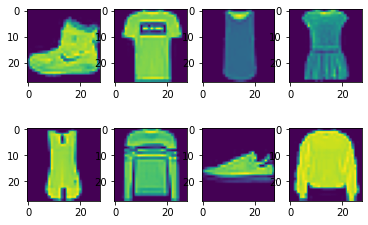

In [4]:
import cv2
from matplotlib import pyplot as plt

fig,axs = plt.subplots(2,4)
for i in range(8):
    axs[i//4, i%4].imshow(train_images[i])
plt.show()

In [5]:
label_names = ("T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot")
assert len(label_names) == 10

## Dimensionality reduction
So if we want to look at the dataset as a whole and understand how it looks like then we want to plot the 60k points
in the 28*28=784 dimensional space. Since i understand 2 dimensions best we will reduce this to 2 dimensions and make some plots.

## Stupid way
Easiest way would be to just take two of the 784 dimensions. This should show us very little of the structure of the data.
But it shows that its not a trivial problem.

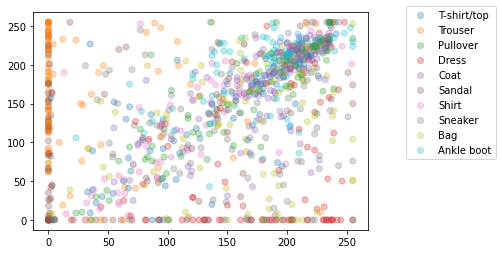

In [6]:
from matplotlib.colors import ListedColormap, TABLEAU_COLORS
import random
def plot_embedding(train_images, train_labels, d1, d2):
    random.seed(37)
    index = random.choices(list(range(len(train_labels))),k=1000)
    img_sample = train_images[index,:]
    label_sample = train_labels[index]
    colors = ListedColormap(TABLEAU_COLORS, N=10)
    scatter = plt.scatter(img_sample[:,d1[0],d1[1]], img_sample[:, d2[0],d2[1]], c=label_sample, cmap=colors, alpha=0.3)
    plt.legend(handles=scatter.legend_elements()[0], labels=label_names, bbox_to_anchor=(1.1, 1.05))
plot_embedding(train_images, train_labels, (14, 14), (10,18))

Often one of the variables is 0, the background color, and often the dimensions have the same color as we can see
more points on the diagional.
Its quite noisy and we can not see too much. Lets first get PCAs opinion on this dataset.

# Principal Component Analysis (PCA)

PCA finds the eigenvectors of the covariance matrix. These will be a set of orthogonal vectors that point into the direction of the highest variance of the dataset. If we then project the data onto a subset of these vectors then we get an embedding into a smaller space.
PCA works only on two dimensional matrices so we need to flatten the 28x28 pictures.

In [7]:
X_train_flat = train_images.reshape(train_images.shape[0], -1)
assert X_train_flat.shape == (train_images.shape[0], train_images.shape[1]*train_images.shape[2])
X_test_flat = test_images.reshape(test_images.shape[0], -1)
assert X_test_flat.shape == (test_images.shape[0], test_images.shape[1]*test_images.shape[2])

In [8]:
from sklearn.decomposition import PCA
for n in [2,3,10,100,784]:
    pca = PCA(n_components=n)
    pca.fit(X_train_flat)
    print(f"Variance lost during pca projection to {n}-dimensions: {(1-sum(pca.explained_variance_ratio_)):.2f}")


Variance lost during pca projection to 2-dimensions: 0.53
Variance lost during pca projection to 3-dimensions: 0.47
Variance lost during pca projection to 10-dimensions: 0.28
Variance lost during pca projection to 100-dimensions: 0.09
Variance lost during pca projection to 784-dimensions: -0.00


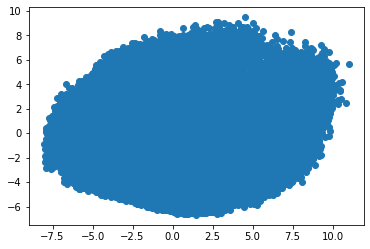

In [9]:
pca = PCA(n_components=2)
pca.fit(X_train_flat/255)
X_train_pca = pca.transform(X_train_flat/255)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1])

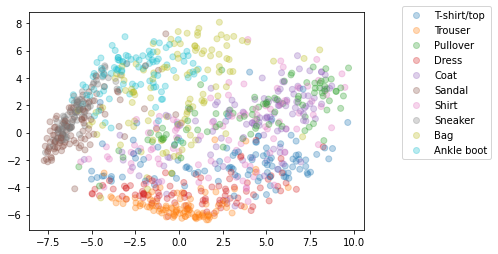

In [10]:
plot_embedding(X_train_pca, train_labels, (0, None), (1,None))


wow this looks already much better!
sandle and ankle boot which are both shoes are in the top left.
Trousers are consistently at the bottom.
I think by adding a line here it can quite reliably tell trousers from shoes appart even without neuralnetworks.

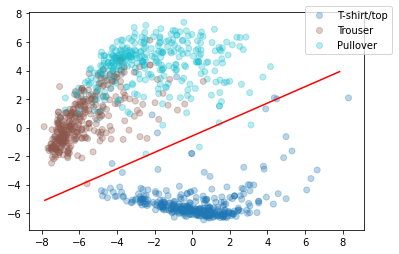

In [11]:
# Manual sandal or trouser classifier:

mask = [x in (1,5,9) for x in train_labels]
plot_embedding(X_train_pca[mask,:], train_labels[mask], (0, None), (1,None))
plt.plot([-2000/255, 2000/255], [-1300/255, 1000/255], 'k-', color = 'r')

PCA is a real transformer and this is an embedding. So if i make up a new picture like from test_images then i can transform this into 2-d space and work with it there.


In [12]:
print(pca.transform(test_images[[0]].reshape(1,-1)/255))
print(label_names[test_labels[0]])

[[-5.83301194  2.57030226]]
Ankle boot


# T-SNE
tsne initializes all the points randomly in the desired dimensionality space and then optimizes the positions of the points such that the distances of two points in the reduced space are similar to the distances of these points in the higher dimension.

I run this just on a subset as its rather slow.

In [13]:
%%time
from sklearn.manifold import TSNE
tf.random.set_seed(1234)
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train_flat[:10000,:])

CPU times: user 4min 56s, sys: 5.15 s, total: 5min 1s
Wall time: 27.8 s


tsne embedding:
We can clearly see that it seperated Trouser, (Sandle, Ankle boot, Sneaker) , Bag and rest (tshirt, pullover...)

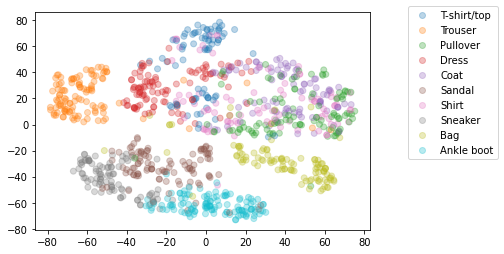

In [14]:
plot_embedding(X_train_tsne, train_labels[:10000], (0, None), (1,None))


Keep in mind that this is an unsupervised algorithm. We didnt tell it to seperate trousers or that these are trousers
it just saw in the data: "these pictures look similar". So its amazing.
Unfortunately this does not create a transformer. This just moves around the points in the space until their 
distances to each other in the smaller space (2 dim) are similar to the distances in the larger space (784 dim).

So even though these points are clearly seperated we can not use this on the test data to distinguish shoes from
trousers. Its more to explore the data set.
So i think we want to create such an embedding but also have a non linear transformation function like a neural network.

In [15]:
# todo try https://github.com/lmcinnes/umap and https://github.com/cvxgrp/pymde

# Autoencoder

So the idea is that if we have a lot of data but no labels. Then we create a neural network that should output the
input, so learn the identity function. But in one of the hidden layers we use only a small number of neurons e.g. 2 
and if it wants to recover a lot from the original image then it needs to pack all these information into these 2 
numbers. Which can be understood as a 2 dimensional embedding.

In [16]:
from tensorflow import keras
# lets start with a simple design on the flattened data that should be similar to the above.
input_ = keras.layers.Input(shape=[784])
hidden1 = keras.layers.Dense(50, activation="relu")(input_)
hidden2 = keras.layers.Dense(2, activation='relu')(hidden1)
encoder = keras.Model(inputs=[input_], outputs=hidden2)

input_ = keras.layers.Input(shape=[2])
hidden3 = keras.layers.Dense(50, activation='relu')(input_)
output = keras.layers.Dense(784, activation='linear')(hidden3)
decoder = keras.Model(inputs=[input_], outputs=[output])
from keras.models import Sequential
autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

Since these are pictures i think it should be better to use convolutions

In [17]:
X_train_fs = X_train_flat/255
X_test_fs = X_test_flat/255
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(x=X_train_fs, y=X_train_fs, epochs=100)

Epoch 1/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0631
Epoch 2/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0534
Epoch 3/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0509
Epoch 4/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0500
Epoch 5/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0495
Epoch 6/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0494
Epoch 7/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0492
Epoch 8/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0490
Epoch 9/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0488
Epoch 10/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0486
Epoch 11/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0483
Epoch 12/100
1875/1875 [==============================] - 2s 1ms/step - lo

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0283
Epoch 98/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0282
Epoch 99/100
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0283
Epoch 100/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0283


In [18]:
# I think this does not easily overfit? but lets check.
pred=autoencoder.predict(X_train_fs)

1875/1875 [==============================] - 2s 1ms/step


In [19]:
pred_tr = autoencoder.predict(X_train_fs, verbose=0)
print(f"train error: {np.mean(abs(pred_tr - X_train_fs)):.2f}")
X_test_fs = X_test_flat/255
pred_test = autoencoder.predict(X_test_fs, verbose=0)
print(f"test error: {np.mean(abs(pred_test - X_test_fs)):.2f}")

train error: 0.10
test error: 0.10


<AxesSubplot:>

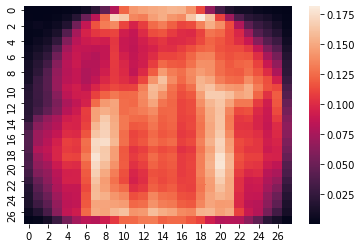

In [20]:
errors = np.mean(abs(pred_tr - X_train_fs), axis=0).reshape(img_size, img_size)
import seaborn as sns
sns.heatmap(errors)

I think not too bad for only two dimensions. It can recover some classes but its just not enough dimensions for all 
10 different categories.


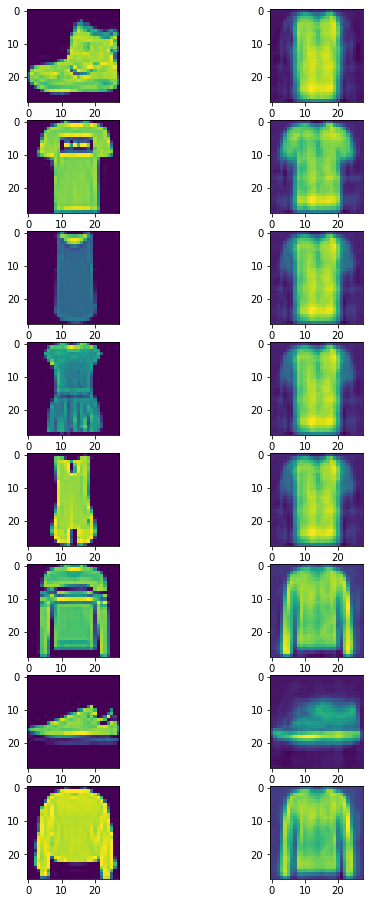

In [21]:
fig, ax = plt.subplots(8,2, figsize=(8,16))
fig
for i in range(8):
    ax[i][0].imshow(train_images[i])
    emb = encoder.predict(train_images[i,:].reshape(1,-1), verbose=0)
    pred_im = decoder.predict(emb,verbose=0).reshape(img_size, img_size)
    ax[i][1].imshow(pred_im)

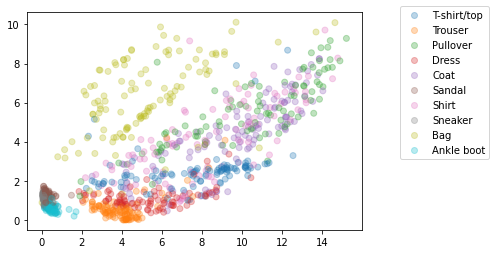

In [22]:
x_train_emb = encoder.predict(X_train_fs, verbose=0)
plot_embedding(x_train_emb, train_labels, (0, None), (1, None))

Seems to have worked that shoes are together and bags are seperated from them but spread.
All trousers are grouped but not seperated from the rest. So definetly worse than tsne maybe similar to pca or 
slightly better.
I think we need some more dimensions in the bottleneck and i would try convolutions to improve the autoencoder.

One cool thing about this is that we immediately also get a generator. So by just sampling out of the embedding space
we can create new images. They are blurry as is often critized about Autoencoders for generation compared to GAN 
and ofcourse we took way too small embedding dimension.

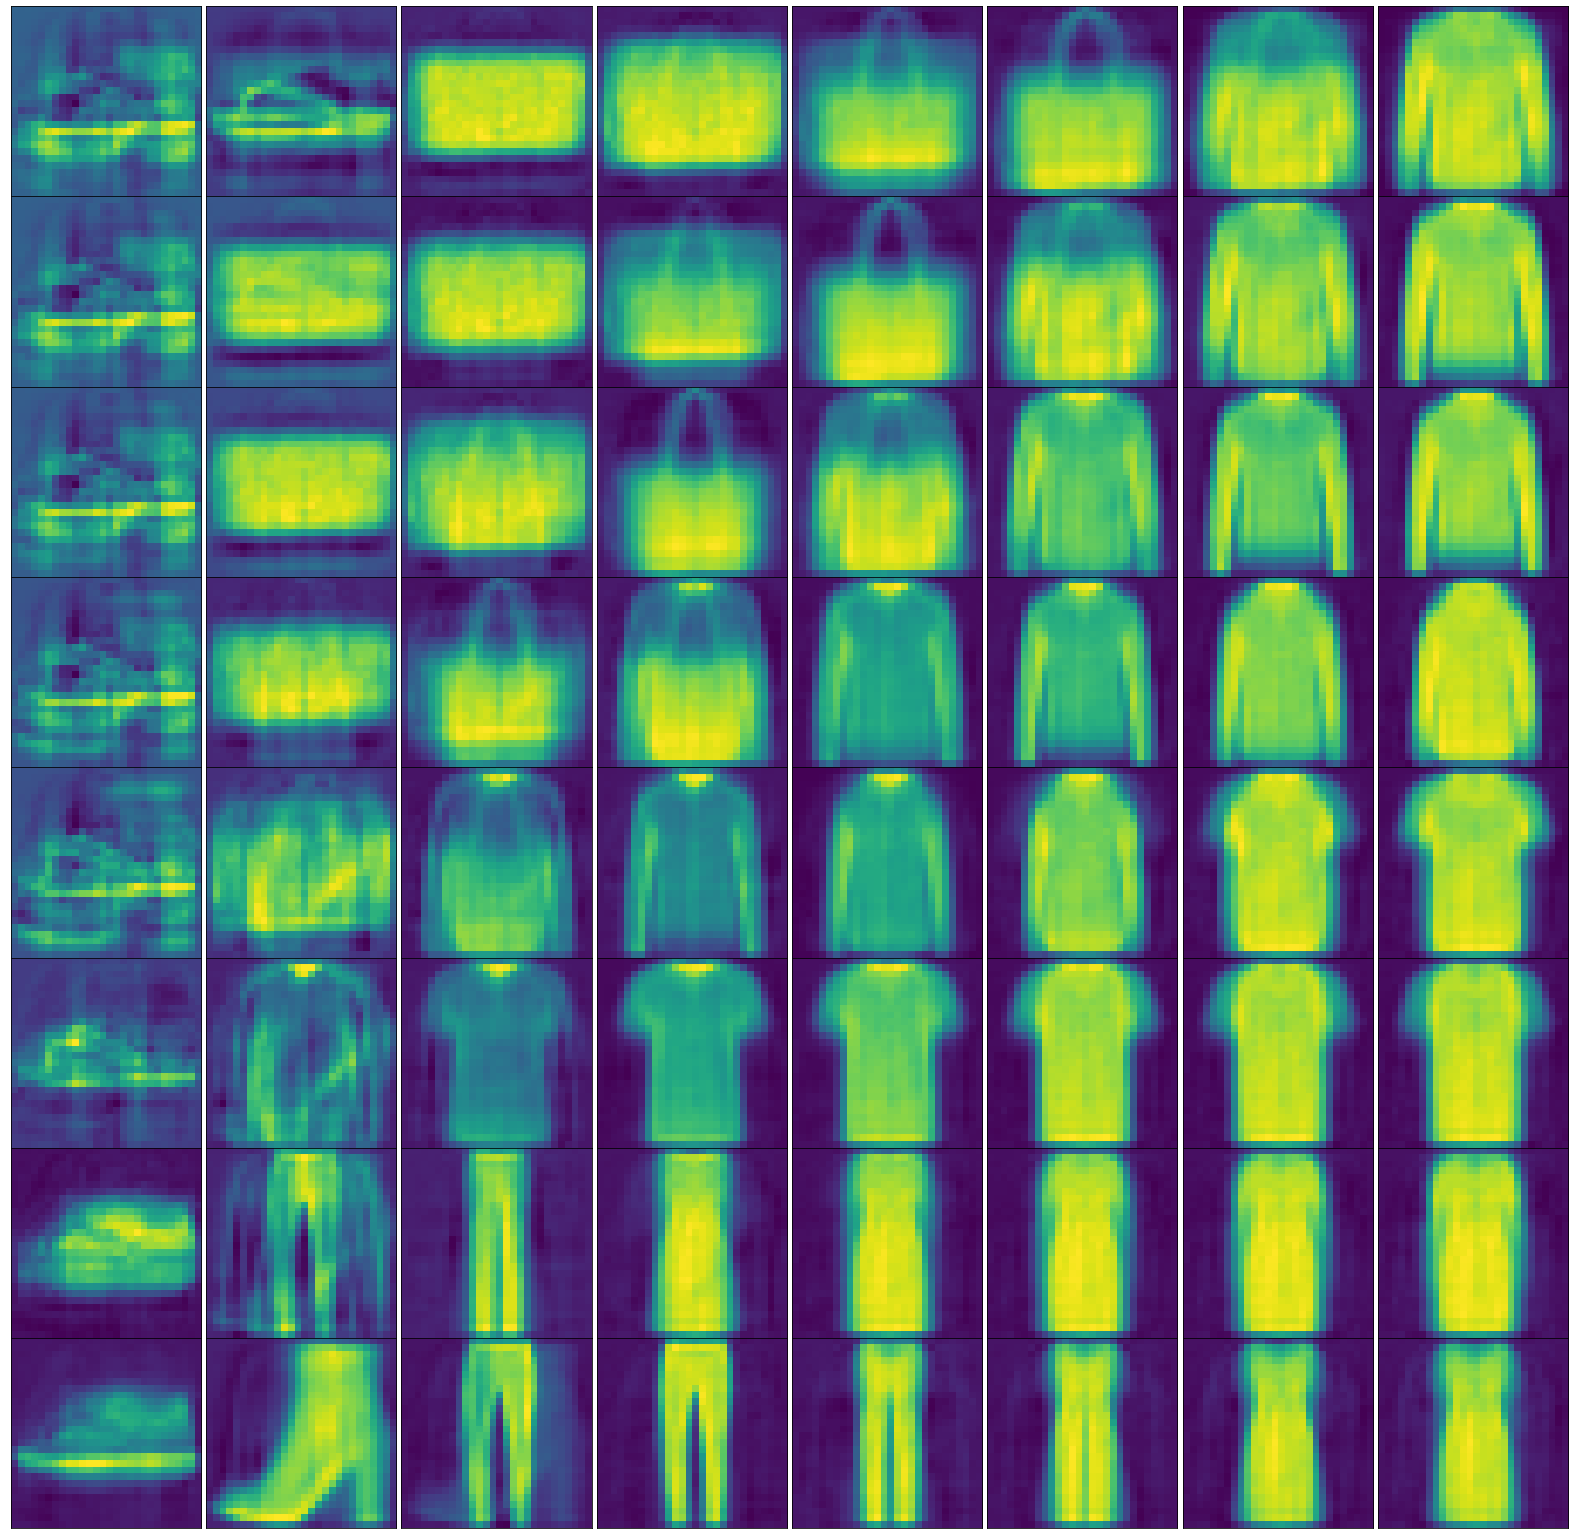

In [23]:
ylim = 8
xlim = 8
fig, ax = plt.subplots(xlim, ylim, figsize=(28,28))
for x in range(xlim):
    for y in range(ylim):
        ax[xlim-1-x][y].imshow(decoder.predict(np.array([[1.5*y, x]]), verbose=0).reshape(img_size, img_size))
        ax[xlim-1-x][y].xaxis.set_visible(False)
        ax[xlim-1-x][y].yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [24]:
# todo: VAE Variational autoencoder and GAN (Generative Adversarial Networks)

I think in practice to get embeddings you train a big classifcation conv net on labeled data and have some hidden layer with the desired embedding dimension.

# Unsupervised pre training vs Transfer Learning

Ok lets say we have just 100 pictures that are labeled but many that are unlabeled. Which is a realistic scenario in
practice.

# Transfer Learning

Take a famous Deep Learning model that is trained on millions of images and has proven to be very good. Then 
take the features that it has learned to analyze pictures and add some layers at the end to learn new ways of combining the useful image features to solve our task.

The most famous dataset that i know is imagenet. It has a lot of different types of images inside so i would expect this to be useful for real world usecases.
I decided to take the smallest efficientnet because its rather small so its quick to predict and train and analyze.

In [25]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
    classes=10,
    classifier_activation="softmax",
)

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
def preprocess_y(small_labels, test_labels):
    encoder = OneHotEncoder().fit(small_labels.reshape(-1, 1))
    y_train_one_hot = encoder.transform(small_labels.reshape(-1, 1)).toarray()
    y_test_one_hot = encoder.transform(test_labels.reshape(-1, 1)).toarray()
    return y_train_one_hot, y_test_one_hot

def preprocess_y_to_effnet(small_labels: np.array, test_labels: np.array):
    y_train_one_hot, y_test_one_hot = preprocess_y(small_labels, test_labels)
    y_test_one_hot_effnet = y_test_one_hot.reshape((test_labels.shape[0],1,1,10))
    y_train_one_hot_effnet = y_train_one_hot.reshape((small_labels.shape[0],1,1,10))
    return y_train_one_hot_effnet, y_test_one_hot_effnet


In [27]:
# lets not destroy our precious learned features for image classification
effnet.trainable = False
# not sure which layer is best for this.
effnet_cut = keras.Model(inputs=effnet.input, outputs=effnet.layers[-3].output) 

In [28]:
effnet_cut.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 32, 32, 3)    0           ['normalization[0][0]']          
                                                                                            

                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 8, 8, 144)   576         ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 8, 8, 144)   0           ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 8, 8, 144)   1296        ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_b

 block3b_dwconv (DepthwiseConv2  (None, 4, 4, 240)   6000        ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 4, 4, 240)   960         ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 4, 4, 240)   0           ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
          

 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 2, 2, 480)    0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 2, 2, 112)    53760       ['block5a_se_excite[0][0]']      
          

                                                                                                  
 block5c_project_bn (BatchNorma  (None, 2, 2, 112)   448         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 2, 2, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 2, 2, 112)    0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 2, 2, 672)    75264       ['block5c_add[0][0]']            
          

                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 1, 1, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 1, 1, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 1, 1, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_d

 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 1, 1, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 1, 1, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 1, 1, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
          

In [29]:
# kind of hacky preprocessing because effnet expects three color channels and more pixels.
def preprocess_to_effnet(small_train, test_images):
    min_resnet_resolution = (32,32)
    X_train32 = np.array([cv2.resize(small_train[i,:], min_resnet_resolution).reshape(32,32,1) for i in range(small_train.shape[0])])
    X_test32 = np.array([cv2.resize(test_images[i,:], min_resnet_resolution).reshape(32,32,1) for i in range(test_images.shape[0])])
    X_train32_32_3 = cv2.merge([X_train32,X_train32,X_train32]).reshape((X_train32.shape[0],32,32,-1))
    X_test32_32_3 = cv2.merge([X_test32,X_test32,X_test32]).reshape((X_test32.shape[0],32,32,-1))
    return X_train32_32_3, X_test32_32_3

# tips from keras https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
# small learning rate, smaller effnet are easier to tune, keep batchnorm layers frozen
def eval_effnet(small_train, small_labels, test_images, test_labels, effnet=effnet_cut)->float:
    dense1 = keras.layers.Dense(512, activation='relu')(effnet.output, training=True)
    dropout1= keras.layers.Dropout(rate=0.25)(dense1)
    output = keras.layers.Dense(10, activation='softmax')(dense1)
    new_model = keras.Model(inputs=effnet.input, outputs=output)

    X_train, X_test = preprocess_to_effnet(small_train, test_images)
    y_train, y_test = preprocess_y_to_effnet(small_labels, test_labels)
    optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    new_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    new_model.fit(X_train, y_train, epochs=100, verbose=0)
    loss, acc_test = new_model.evaluate(X_test, y_test, verbose=0)
    loss,acc_train = new_model.evaluate(X_train, y_train, verbose=0)
    return acc_train, acc_test

# Train a ConvNet from scratch

As a baseline we just train a conv net from scratch without transfer learning or unsupervised pre training.
I just googled a set of parameters that was said to be decent. So these parameters have been tuned (overfitted?) on
this dataset, but lets takem anyway so that a potential success of one of the other methods is not because of poorly tuned hyperparameters.

In [30]:

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
def build_nn():
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(28,28, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    return model

def eval_baseline(small_train, small_labels, test_images, test_labels):
    y_train_one_hot, y_test_one_hot = preprocess_y(small_labels, test_labels)
    model = build_nn()
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer = optimizer,loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
    model.fit(small_train, y_train_one_hot, epochs=100, verbose=0)
    loss,acc_test = model.evaluate(test_images, y_test_one_hot, verbose=0)
    loss,acc_train = model.evaluate(small_train, y_train_one_hot, verbose=0)

    return acc_train, acc_test

# 3) Unsupervised pre training
Unsupervised Learning on the full dataset to learn a representation and then learn a classifier on the small labeled dataset from that representation.

In [34]:
def build_autoencoder(train_images):
    bootleneck_size = 15
    input_ = keras.layers.Input(shape=[28,28])
    input_flat = keras.layers.Flatten()(input_)
    hidden1 = keras.layers.Dense(100, activation="relu")(input_flat)
    hidden2 = keras.layers.Dense(bootleneck_size, activation='relu')(hidden1)
    encoder = keras.Model(inputs=[input_], outputs=hidden2)

    input_ = keras.layers.Input(shape=[bootleneck_size])
    hidden3 = keras.layers.Dense(100, activation='relu')(input_)
    output = keras.layers.Dense(784, activation='linear')(hidden3)
    output2d = keras.layers.Reshape((28,28))(output)
    decoder = keras.Model(inputs=[input_], outputs=[output2d])
    from keras.models import Sequential
    autoencoder = Sequential()
    autoencoder.add(encoder)
    autoencoder.add(decoder)
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    autoencoder.compile(optimizer = optimizer,loss=keras.losses.mean_squared_error)
    autoencoder.fit(x=train_images/255, y=train_images/255, epochs=40, verbose=0)
    return encoder, autoencoder

def eval_ae_unsup(small_train, small_labels, test_images, test_labels, encoder=encoder):
    input_ = keras.layers.Input(shape=[28,28])
    embedding = encoder(input_)
    embedding.trainable=False
    dense1=keras.layers.Dense(20, activation="relu")(embedding)
    dropout1 = keras.layers.Dropout(0.3)(dense1)
    output = keras.layers.Dense(10, activation="softmax")(dropout1)
    ae_unsup = keras.Model(inputs=[input_], outputs=[output])
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    y_train_one_hot, y_test_one_hot = preprocess_y(small_labels, test_labels)
    ae_unsup.compile(optimizer = optimizer,loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
    ae_unsup.fit(small_train, y_train_one_hot, epochs=100, verbose=0)
    loss,acc_test = ae_unsup.evaluate(test_images, y_test_one_hot, verbose=0)
    loss,acc_train = ae_unsup.evaluate(small_train, y_train_one_hot, verbose=0)

    return acc_train, acc_test

encoder10, ae10 = build_autoencoder(train_images)

In [37]:
%%time
import time
base =[]
eff = []
unsup = []
start_time = time.time()
train_sizes = [25, 50, 100, 200, 500]
for n_small in train_sizes:
    small_labels = train_labels[:n_small].copy()
    small_train = train_images[:n_small,:,:].copy()

    tf.random.set_seed(1234)
    acc_base_train, acc_base_test = eval_baseline(small_train/255, small_labels, test_images/255, test_labels)
    print(f"Baseline CNN performance: Train on {small_train.shape[0]} images, Train Accuracy {acc_base_train}")
    print(f"Baseline CNN performance: Train on {small_train.shape[0]} images, Test Accuracy {acc_base_test}")
    base.append(acc_base_test)

    tf.random.set_seed(1234)
    acc_eff_train, acc_eff_test = eval_effnet(small_train, small_labels, test_images, test_labels, effnet=effnet_cut)
    print(f"Effnet performance: Train on {small_train.shape[0]} images, Train Accuracy {acc_eff_train}")
    print(f"Effnet performance: Train on {small_train.shape[0]} images, Test Accuracy {acc_eff_test}")
    eff.append(acc_eff_test)

    tf.random.set_seed(1234)
    acc_ae_train, acc_ae_test = eval_ae_unsup(small_train/255, small_labels, test_images/255, test_labels, encoder=encoder10)
    print(f"Autoencoder pre trained: Train on {small_train.shape[0]} images, Train Accuracy {acc_ae_train}")
    print(f"Autoencoder pre trained: Train on {small_train.shape[0]} images, Test Accuracy {acc_ae_test}")
    unsup.append(acc_ae_test)
    print(time.time()-start_time)


Baseline CNN performance: Train on 25 images, Train Accuracy 0.8799999952316284
Baseline CNN performance: Train on 25 images, Test Accuracy 0.3750999867916107
Effnet performance: Train on 25 images, Train Accuracy 1.0
Effnet performance: Train on 25 images, Test Accuracy 0.4666999876499176
Autoencoder pre trained: Train on 25 images, Train Accuracy 0.9599999785423279
Autoencoder pre trained: Train on 25 images, Test Accuracy 0.49889999628067017
31.643737077713013
Baseline CNN performance: Train on 50 images, Train Accuracy 0.8799999952316284
Baseline CNN performance: Train on 50 images, Test Accuracy 0.5259000062942505
Effnet performance: Train on 50 images, Train Accuracy 1.0
Effnet performance: Train on 50 images, Test Accuracy 0.5486999750137329
Autoencoder pre trained: Train on 50 images, Train Accuracy 1.0
Autoencoder pre trained: Train on 50 images, Test Accuracy 0.6308000087738037
72.46429800987244
Baseline CNN performance: Train on 100 images, Train Accuracy 0.9100000262260437


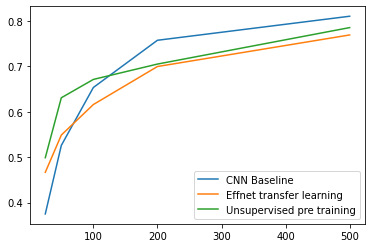

In [38]:
plt.plot(train_sizes,base)
plt.plot(train_sizes,eff)
plt.plot(train_sizes,unsup)
plt.legend(["CNN Baseline", "Effnet transfer learning", "Unsupervised pre training"])

Of course all three strategies get better with more data samples. 
The Autoencoder pre training worked decent especially for very small datasets. I think to scale it for higher numbers of training samples it should have some conv layers.
The Effnet transfer learning is not as easy to tune as i thought. 